In [1]:
import numpy as np
import pandas as pd

filename_titanic="titanic.data"
data_titanic = pd.read_csv(filename_titanic)

filename_tic="tic-tac-toe.data"

data_tic=pd.read_csv(filename_tic)

print("Titanic atributes")
for c in data_titanic.columns:
    print(c, np.unique(data_titanic[c]))
    
print("\nTic-tac-toe atributes")
for c in data_tic.columns:
    print(c, np.unique(data_tic[c]))

Titanic atributes
Pclass [1 2 3]
Sex ['female' 'male']
Age [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Class [0 1]

Tic-tac-toe atributes
TLeftSq ['b' 'o' 'x']
TMidSq ['b' 'o' 'x']
TRightSq ['b' 'o' 'x']
MLeftSq ['b' 'o' 'x']
MMidSq ['b' 'o' 'x']
MRightSq ['b' 'o' 'x']
BLeftSq ['b' 'o' 'x']
BMidSq ['b' 'o' 'x']
BRightSq ['b' 'o' 'x']
Class ['negative' 'positive']


In [54]:
import random
import numpy as np
import pandas as pd

class AlgoritmoGenetico:
    def __init__(self,train_set, diccionario, n_ind):
        self.train=train_set.copy(deep=True)
        self.diccionario=diccionario
        self.encoder_length=0
        self.class_length=len(self.diccionario[-1].values())
        self.population_size=n_ind
        for c in self.diccionario:
            self.encoder_length+=len(c.values())
        self.population=self.generate_population(n_ind)
        self.train_encoded=self.encode(train_set)
        self.best_fitness_history=[]
        self.mean_fitness_history=[]
        
    def rand_key(self,p):  #Return random 0-1 string of fixed size
        key1 = "" 
        for i in range(p): 
            temp = str(random.randint(0, 1)) 
            key1 += temp 
        return(key1) 
    
    def generate_population(self,n): #Generates a new random population of size n
        population=[]
        for i in range(n):
            individual=self.rand_key(self.encoder_length)
            population.append(individual)
        return(population)
    
    def encode(self, rows):
        train_encoded=[]
        for index, row in rows.iterrows():
            row_encoded="0"*self.encoder_length
            i=0
            for idx, at in enumerate(row.values):
                block_pos=self.diccionario[idx][at]
                row_encoded=row_encoded[:i+block_pos]+"1"+row_encoded[i+block_pos+1:]
                i=i+len(self.diccionario[idx])
            train_encoded.append(row_encoded)
        return(train_encoded)
    
    def encode_classify(self, rows):
        train_encoded=[]
        for index, row in rows.iterrows():
            row_encoded="0"*(self.encoder_length-self.class_length)
            i=0
            for idx, at in enumerate(row.values):
                block_pos=self.diccionario[idx][at]
                row_encoded=row_encoded[:i+block_pos]+"1"+row_encoded[i+block_pos+1:]
                i=i+len(self.diccionario[idx])
            train_encoded.append(row_encoded)
        return(train_encoded)
    
    def convert_train_ints(self):  #This converts encoded binary train data set from strings to ints
        train_ints=[]
        for t in self.train_encoded:
            train_ints.append(int(t[:-self.class_length],2))
        return(train_ints)
    
    def count_fitness(self):
        #convert train attributes to ints for bitwise operations
        train_ints=self.convert_train_ints()
        classes_t=[]
        fitness=[]
        #Filtering classes of the train cromosomes
        for t in self.train_encoded:
            classes_t.append(t[-self.class_length:])
        i=0
        for individual in self.population:
            individual_rule=individual[:-self.class_length]  #Filter only the part of the conditions
            individual_rule_int=int(individual_rule,2) #Converting binary string to int for bitwise operations
            induvidual_class=individual[-self.class_length:] #The class of the individual cromosome
            rule_counter=0 
            rule_classes=[]
            for t in range(len(train_ints)): #Comparing the indivudual rules with the train set
                apply_mask=individual_rule_int|train_ints[t] #Or operator will return the same value as indivudual if the rule includes the train condition
                if apply_mask==individual_rule_int:
                    rule_counter+=1 #Counts how many training set rows correspond to the conditions programed in the individual
                    rule_classes.append(classes_t[t]) #Stores the real class of the condition
            rule_classes=np.array(rule_classes)
            assert_class=len(rule_classes[rule_classes==induvidual_class]) #Calculates how many times the idividual predicted the right class
            fitness.append((assert_class/(rule_counter+1)+0.3*rule_counter/len(train_ints))/1.3) #Fitness is the number of right classes divided by the number of apperances+1 of the individual's condition in the train dataset
            #fitness.append(assert_class/len(train_ints)) #Este fitness va a generar la regla que siempre predice clase con max probabilidad priori
            i+=1
        return(fitness)
      
    def choose_parents(self, elite_percent):
        fitness=np.array(self.count_fitness())
        fitness_sum=np.sum(fitness)
        max_fit_id=np.argmax(fitness)
        fitness_prop=fitness/fitness_sum
        fitness_cdf=np.cumsum(fitness_prop)
        elite_num=round(elite_percent*self.population_size)
        elite_counter=0
        parents=[]
        parent_ids=[]
        rand_sel=[]
        for i in range(self.population_size):
            if elite_counter<elite_num:  #Adding the elites without random selection
                parents.append(self.population[max_fit_id])
                elite_counter+=1
            else:
                r=np.random.rand() #Adding the rest based on their fitness
                rand_sel.append(r)
                ind_ids=np.where(fitness_cdf>=r)[0]
                parent_ids.append(ind_ids[0])
                parents.append(self.population[ind_ids[0]])
        return(parents) 
    
    def cross_one_point(self,parent1, parent2):
        pos=np.random.randint(0,self.encoder_length)
        child1=parent1[:pos]+parent2[pos:]
        child2=parent2[:pos]+parent1[pos:]
        return(child1, child2)
    
    def mutate(self, generation, mutation_prob):
        mut_n=round(self.population_size*self.encoder_length*mutation_prob) #number of mutations in population
        rand_n=np.random.rand(mut_n)
        m_pos=rand_n*self.population_size*self.encoder_length #gerenating random positions of mutations
        idx,p=divmod(m_pos,self.encoder_length) #determinings individuals and the position in the cromosome
        p=np.round(p)
        idx=idx.astype(int)
        p=p.astype(int)
        #print("Mutations where done at", idx, p)
        for i in range(mut_n):
            if p[i]==self.encoder_length: 
                p[i]=p[i]-1
            ind=generation[idx[i]]
            ind_list=list(ind)
            #print(ind_list, p[i])
            if ind_list[p[i]]=="1":
                ind_list[p[i]]="0"
            else:
                ind_list[p[i]]="1"
            ind="".join(ind_list)
            generation[idx[i]]=ind
        return(generation)
    
    def generate_next_population(self,elite_percent, mutation_prob, mutate):
        parents=self.choose_parents(elite_percent)
        ft=self.count_fitness()
        self.best_fitness_history.append(np.max(ft))
        self.mean_fitness_history.append(np.mean(ft))
        couples_num=round(self.population_size/2)
        next_generation=[]
        for i in range(couples_num):
            child1,child2=self.cross_one_point(parents[i], parents[i+2])
            next_generation.append(child1)
            next_generation.append(child2)
        #print("Next generation before mutation:", next_generation)
        if mutate:
            next_generation=self.mutate(next_generation, mutation_prob)
        self.population=next_generation
        return(next_generation)
    
    def training(self, iteractions, elite_percent, mutation_prob):
        for i in range(iteractions):
            if i!=iteractions-1:
                generation=self.generate_next_population(elite_percent, mutation_prob, True)
            else:
            #Avoid mutations in last generation
                generation=self.generate_next_population(elite_percent, mutation_prob, False)
            #print("Generation #", i+1, generation)
        #Return unique rules:
        id_best=np.argmax(self.count_fitness())
        self.rule=self.population[id_best]
        self.rules=np.unique(self.population)
        return(self.rule)

    def classify1(self, rows):  #The test one to check classification with all generated rules
        rows_encoded=self.encode_classify(rows)
        #rule_cond=self.rule[:-self.class_length]
        #rule_class=self.rule[-self.class_length:]
        #print(rule_class)
        #print(row_encoded, rule_cond, rule_class)
        #rule_int=int(rule_cond,2)
        self.err=0
        classes=[]
        for r in rows_encoded:
            row_int=int(r,2)
            #apply_mask=rule_int|row_int
            classes=[]
            class_id=[]
            classe_names=[]
            for rule in self.rules:
                #print(rule)
                rule_cond=self.rule[:-self.class_length]
                rule_class=self.rule[-self.class_length:] 
                rule_int=int(rule_cond,2)
                apply_mask=rule_int|row_int
                cl_id=rule_class.find("1")
                if apply_mask==rule_int:
                    class_id.append(rule_class)
                    class_name=self.diccionario[-1][cl_id]
                    classe_names.append(class_name)
                else:
                    cls=self.diccionario[-1]
                    #print("Class id", cl_id, cls[0])
                    if cl_id==0:
                        class_name=self.diccionario[-1][1]
                    else:
                        class_name=self.diccionario[-1][0]
                    classe_names.append(class_name)
                        
                    #class_id.append("Other")
                    #print("wrong class")
            print(r, classe_names)
            classes.append(class_id)
    def classify(self, rows): #Classifies with the rule that has best fitness
        rows_encoded=self.encode_classify(rows)
        classes_dict=self.diccionario[-1]
        classes=[]
        for r in rows_encoded:
            row_int=int(r,2)
            rule_cond=self.rule[:-self.class_length]
            rule_class=self.rule[-self.class_length:] 
            rule_int=int(rule_cond,2)
            apply_mask=rule_int|row_int
            cl_id=rule_class.find("1")
            if apply_mask==rule_int:
                class_name=list(classes_dict.keys())[list(classes_dict.values()).index(cl_id)]
            else:
                if cl_id==0:
                    class_name=list(classes_dict.keys())[list(classes_dict.values()).index(1)]
                else:
                    class_name=list(classes_dict.keys())[list(classes_dict.values()).index(0)]
            classes.append(class_name)
        return(classes)
    def error(self, test):
        predicted_class=self.classify(test.iloc[:,:-1])
        real_class=test.iloc[:,-1]
        i=0
        count=0
        for c in real_class:
            if c==predicted_class[i]:
                count+=1
            i+=1
        err=1-count/test.shape[0]
        return(err)
    def represent_rule(self, column_names):
        i=0
        column_i=0
        query="IF "
        for atts in self.diccionario[:-1]:
            l=len(atts)
            ch=self.rule[i:i+l]
            c_i=0
            c_inrule=0
            for c in ch:
                #print(c)
                if c=="1":
                    if c_inrule!=0:
                        query=query+" OR "
                    att=list(atts.keys())[list(atts.values()).index(c_i)]
                    query=query+column_names[column_i]+"="+str(att)
                    c_inrule+=1
                c_i+=1
            if c_inrule>0 and column_i<len(column_names)-1: 
                query=query+" AND "
                c_inrule=0
            i+=l
            column_i+=1
        return(query)
        

                                

In [55]:
from Datos import *
dataset_titanic=Datos(filename_titanic)

tit_dic=dataset_titanic.diccionario
print(tit_dic)
titanic=AlgoritmoGenetico(data_titanic,tit_dic, 150)

#train_encoded=titanic.encode(data_titanic)
rule=titanic.training(100,0.05, 0.01)

#print(titanic.rules)
#print(titanic.count_fitness())
print(rule)
column_names=data_titanic.columns.values[:-1]
print(titanic.represent_rule(column_names))

cl=titanic.classify(data_titanic.iloc[:,:-1])

print("Error", titanic.error(data_titanic))
    

[{1: 0, 2: 1, 3: 2}, {'female': 0, 'male': 1}, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15}, {0: 0, 1: 1}]


C:\Users\quaxoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


11010011110111110010101
IF Pclass=1 OR Pclass=2 AND Sex=female AND Age=1 OR Age=2 OR Age=3 OR Age=4 OR Age=6 OR Age=7 OR Age=8 OR Age=9 OR Age=10 OR Age=13 OR Age=15
Error 0.2533460803059273


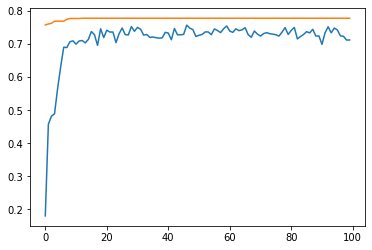

In [244]:
import matplotlib.pyplot as plt
mean_fitness=titanic.mean_fitness_history
best_fitness=titanic.best_fitness_history
#print(best_fitness)
it=range(len(best_fitness))
plt.plot(it, mean_fitness)
plt.plot(it, best_fitness)

Error all data

In [57]:
dataset_tic=Datos(filename_tic)
#print(row, data_titanic.iloc[[1],-1])
tic_dic=dataset_tic.diccionario
print(tic_dic)
tictoc=AlgoritmoGenetico(data_tic,tic_dic, 150)

rule=tictoc.training(100,0.05, 0.01)

print(rule)
column_names_tic=data_tic.columns.values[:-1]
print(tictoc.represent_rule(column_names_tic))
cl=tictoc.classify(data_tic.iloc[:,:-1])
#print(cl)
print("Error", tictoc.error(data_tic))

[{'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'b': 0, 'o': 1, 'x': 2}, {'negative': 0, 'positive': 1}]


C:\Users\quaxoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


11111110111110111110111111101
IF TLeftSq=b OR TLeftSq=o OR TLeftSq=x AND TMidSq=b OR TMidSq=o OR TMidSq=x AND TRightSq=b OR TRightSq=x AND MLeftSq=b OR MLeftSq=o OR MLeftSq=x AND MMidSq=b OR MMidSq=x AND MRightSq=b OR MRightSq=o OR MRightSq=x AND BLeftSq=b OR BLeftSq=x AND BMidSq=b OR BMidSq=o OR BMidSq=x AND BRightSq=b OR BRightSq=o OR BRightSq=x
Error 0.4279749478079332
